# Goal:
Train a simple model on the MVP dataset

In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
sns.set()
%matplotlib notebook

data_path = os. getcwd()[:-9] +'Data/'

In [2]:
df =  pd.read_csv(data_path+'df_mvp.csv')
df.time_bin = pd.to_datetime(df.time_bin)

In [3]:
df.head(3)

,time_bin,label,source,current_popularity,wind_speed,temp,status_good,status_maybe,status_bad,dayofweek,hour
0,2020-03-23 14:35:00,0.0,mis/imp,42.0,26.598094,37.846753,0.0,0.0,1.0,0,14
1,2020-03-23 14:50:00,0.0,obs,42.0,25.900000,37.940000,0.0,0.0,1.0,0,14
2,2020-03-23 15:05:00,0.0,mis/imp,43.0,26.427817,38.125302,0.0,0.0,1.0,0,15


## Train a logistic regression model

In [4]:
from sklearn.model_selection import train_test_split
X = df.iloc[:,3:]
y = df.label
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [5]:
from sklearn.linear_model import LogisticRegression
clf = LogisticRegression(random_state=0,solver ='liblinear', penalty='l1').fit(X_train, y_train)

In [6]:
from sklearn.metrics import classification_report

predictions = clf.predict(X_test)
print(classification_report(y_test,predictions))

              precision    recall  f1-score   support

         0.0       0.56      0.64      0.60        84
         1.0       0.59      0.50      0.54        86

    accuracy                           0.57       170
   macro avg       0.57      0.57      0.57       170
weighted avg       0.57      0.57      0.57       170



In [7]:
from sklearn.metrics import roc_auc_score, roc_curve

def roc_auc(model,model_name, X_test, y_test):
    # generate a no skill prediction (majority class)
    ns_probs = [0 for _ in range(len(y_test))]
    # predict probabilities
    lr_probs = model.predict_proba(X_test)
    # # keep probabilities for the positive outcome only
    lr_probs = lr_probs[:, 1]
    # calculate scores
    ns_auc = roc_auc_score(y_test, ns_probs)
    lr_auc = roc_auc_score(y_test, lr_probs)
    # summarize scores
    print('No Skill: ROC AUC=%.3f' % (ns_auc))
    print(model_name+': ROC AUC=%.3f' % (lr_auc))
    # calculate roc curves
    ns_fpr, ns_tpr, _ = roc_curve(y_test, ns_probs)
    lr_fpr, lr_tpr, _ = roc_curve(y_test, lr_probs)
    # plot the roc curve for the model
    plt.figure()
    plt.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
    plt.plot(lr_fpr, lr_tpr, marker='.', label=model_name)
    # axis labels
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend(); plt.show()

No Skill: ROC AUC=0.500
clf: ROC AUC=0.634


<IPython.core.display.Javascript object>


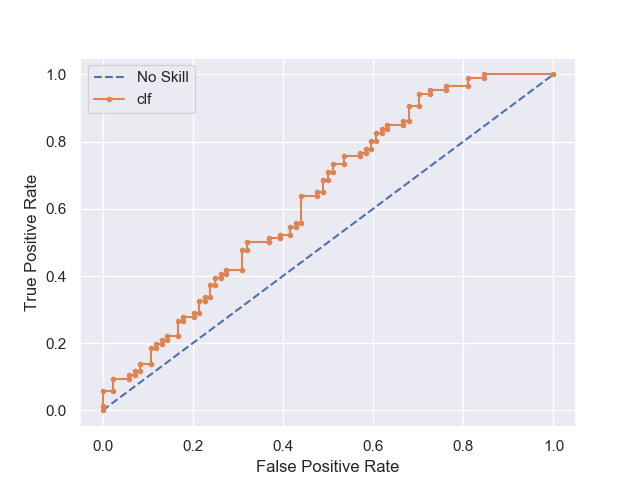

In [8]:
roc_auc(clf,'clf', X_test, y_test)

In [9]:
sorted(list(zip(X.columns,clf.coef_[0])), key = lambda x: x[1],reverse=True) 

[('hour', 0.05167553563427402),
 ('current_popularity', 0.02002598760568136),
 ('status_good', 0.0),
 ('status_bad', 0.0),
 ('temp', -0.002878735882359565),
 ('wind_speed', -0.006638831569161795),
 ('dayofweek', -0.053450359847945356),
 ('status_maybe', -0.3127047320978654)]

## upsample both labels

In [10]:
from sklearn.utils import resample

n_target = 1000
# Separate majority and minority classes
df_mj = df[df.label==0] # safe
df_mi = df[df.label==1] # unsafe
 
# Upsample minority class, with replacement 
df_mi_up = resample(df_mi, replace=True, n_samples=n_target, random_state=101) 
df_mj_up = resample(df_mj, replace=True, n_samples=n_target, random_state=101) 
 
# Combine majority class with upsampled minority class
df_up= pd.concat([df_mj_up, df_mi_up])
 
# Display new class counts
df_up.label.value_counts()

1.0    1000
0.0    1000
Name: label, dtype: int64

In [11]:
X_up = df_up.iloc[:,3:]
y_up = df_up.label

X_train_up, X_test_up, y_train_up, y_test_up = train_test_split(X_up, y_up, test_size=0.33, random_state=42)

clf_up = LogisticRegression(random_state=0,solver ='liblinear', penalty='l1').fit(X_train_up, y_train_up)

In [12]:
predictions_up = clf_up.predict(X_test_up)
print(classification_report(y_test_up,predictions_up))

              precision    recall  f1-score   support

         0.0       0.62      0.72      0.67       325
         1.0       0.68      0.58      0.62       335

    accuracy                           0.65       660
   macro avg       0.65      0.65      0.64       660
weighted avg       0.65      0.65      0.64       660



No Skill: ROC AUC=0.500
clf_up: ROC AUC=0.704


<IPython.core.display.Javascript object>


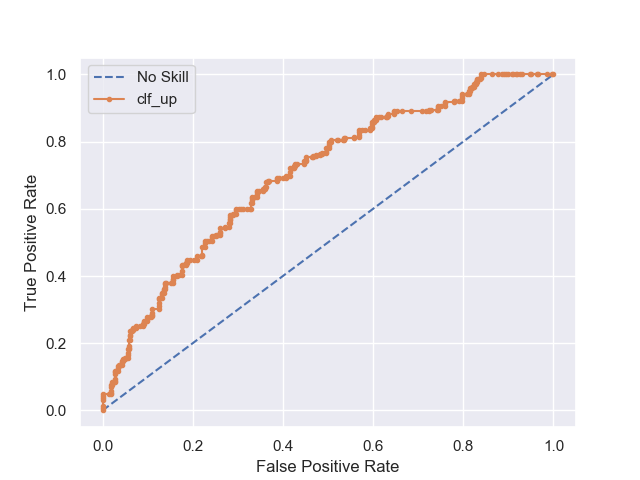

In [13]:
roc_auc(clf_up,'clf_up', X_test_up, y_test_up)

In [14]:
sorted(list(zip(X.columns,clf_up.coef_[0])), key = lambda x: x[1],reverse=True) 

[('hour', 0.022666061202080076),
 ('current_popularity', 0.020159212514875922),
 ('temp', 0.014517356340877956),
 ('dayofweek', 0.0003118751425081791),
 ('status_good', 0.0),
 ('wind_speed', -0.01045430940140884),
 ('status_bad', -0.3183909038763833),
 ('status_maybe', -0.3765106797403286)]

## Train a random forest model

In [15]:
from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier(random_state=0).fit(X_train, y_train)

In [16]:
predictions_rfc = rfc.predict(X_test)
print(classification_report(y_test,predictions_rfc))

              precision    recall  f1-score   support

         0.0       0.79      0.76      0.78        84
         1.0       0.78      0.80      0.79        86

    accuracy                           0.78       170
   macro avg       0.78      0.78      0.78       170
weighted avg       0.78      0.78      0.78       170



No Skill: ROC AUC=0.500
rfc: ROC AUC=0.858


<IPython.core.display.Javascript object>


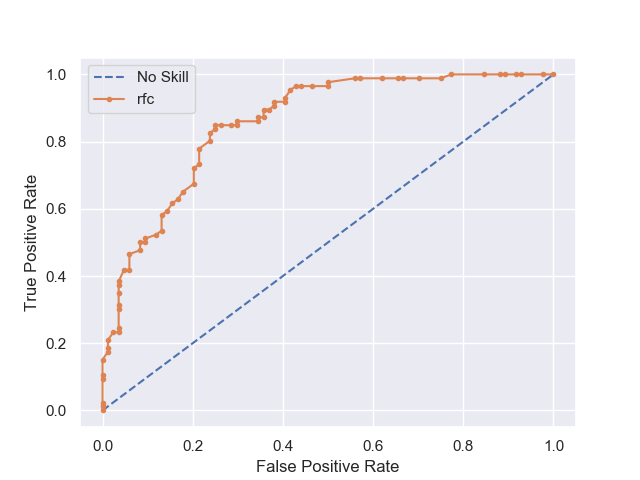

In [17]:
roc_auc(rfc,'rfc', X_test, y_test)

In [18]:
sorted(list(zip(X.columns,rfc.feature_importances_)), key = lambda x: x[1],reverse=True) 

[('temp', 0.2669554445639766),
 ('current_popularity', 0.22862099860334456),
 ('wind_speed', 0.17914098050561006),
 ('hour', 0.17045858958090182),
 ('dayofweek', 0.09613998715220912),
 ('status_maybe', 0.021699993007129496),
 ('status_good', 0.02157858582210575),
 ('status_bad', 0.015405420764722556)]

In [19]:
# Not bad. Save
pickle.dump(rfc, open(os. getcwd()[:-9] +'Model/rfc_HW.pkl', 'wb'))

## RFC and upsampling

In [21]:
rfc_up = RandomForestClassifier(random_state=0).fit(X_train_up, y_train_up)

In [22]:
predictions_rfc_up = rfc.predict(X_test_up)
print(classification_report(y_test_up,predictions_rfc_up))

              precision    recall  f1-score   support

         0.0       0.94      0.90      0.92       325
         1.0       0.91      0.94      0.93       335

    accuracy                           0.92       660
   macro avg       0.92      0.92      0.92       660
weighted avg       0.92      0.92      0.92       660



No Skill: ROC AUC=0.500
rfc_up: ROC AUC=0.999


<IPython.core.display.Javascript object>


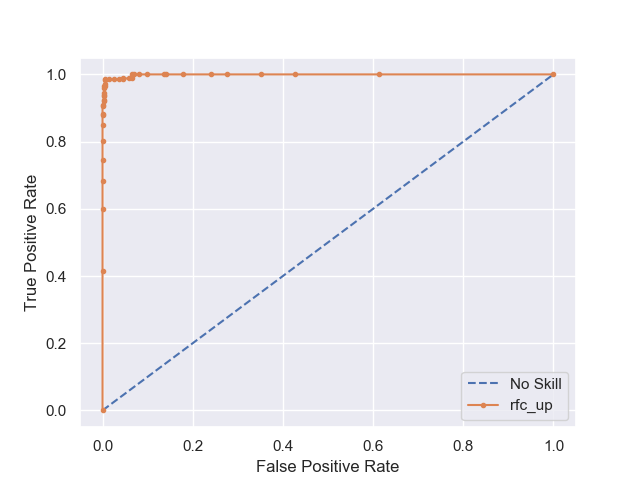

In [23]:
roc_auc(rfc_up,'rfc_up', X_test_up, y_test_up)

In [24]:
sorted(list(zip(X.columns,rfc_up.feature_importances_)), key = lambda x: x[1],reverse=True) 

[('temp', 0.2716191299350993),
 ('current_popularity', 0.23131501188654313),
 ('wind_speed', 0.18675063394359345),
 ('hour', 0.15988413327457773),
 ('dayofweek', 0.09302507202919205),
 ('status_good', 0.02316339644100232),
 ('status_maybe', 0.01853218162503109),
 ('status_bad', 0.015710440864961005)]

In [25]:
pickle.dump(rfc_up, open(os. getcwd()[:-9] +'Model/rfc_up_HW.pkl', 'wb'))